
Copyright 2021 DeepMind Technologies Limited

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

https://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

# Reimplimitation of DeepMind Colab
- [Original Notebook](https://colab.research.google.com/github/deepmind/mathematics_conjectures/blob/main/knot_theory.ipynb)
- [Original Repo](https://github.com/google-deepmind/mathematics_conjectures)
- [Nature Paper](https://www.nature.com/articles/s41586-021-04086-x)

A few slight modifications.

### Just edit the next line and hit run

In [1]:
hidden_layers = [2,2]

## Some of our results
Numbers may vary. With smaller networks the network will likely stop training at the max number of training steps (10k in original)
All results in this table are with identical settings except changing the hidden layer.
(Your numbers may vary slightly, especially in smaller networks. See tips below)
| Network | Number of Parameters | Accuracy Pre Salient | Accuracy Post Salient |
|:--------|---------------------:|---------------------:|----------------------:|
|[300,300,300] | 190,214 | 0.8137779 | 0.8013719 |
|[100,100,100] | 23,414 | 0.82789063 | 0.8204076 |
|[50,50,50] | 6,714 | 0.8512915 | 0.8164692 |
|[10,10,10] | 554 | 0.8444977 | 0.82296765 |
|[5,5,5] | 234 | 0.83061475 | 0.80422723 |
|[4,4,4] | 182 | 0.7673045 | 0.6519413 |
|[3,3,3] | 134 | 0.66332996 | 0.74925333 | 
| - | - | - | - |
|[50,50] | 4,164 | 0.87154156 | 0.8265122 |
|[10,10] | 444 | 0.8302209 | 0.8149923 |
|[5,5] | 204 | 0.82191736 | 0.8132528 |
|[4,4] | 162 | 0.81886506 | 0.810299 |
|[3,3] | 122 | 0.77718335 | 0.76238143 |

Here are some results where we have changed the random seed and training length. We set `num_training_steps` to 50k for an arbitrarially long run and report how many steps before the network early stopped (`Steps`)
| Network | Number of Parameters | seed | Accuarcy Pre Salient | Steps | Accuracy Post Salient | Steps |
|:--------|---------------------:|:----:|---------------------:|:-----:|----------------------:|:-----:|
| [3,3] | 122 | 552 | 0.8160097 | 20700 | 0.81686306 | 22100 |
| [2,2] | 84 | 8110 | 0.81328565  | 22700 | 0.8043914 | 23300 |
    

## User Defined Parameters
We've moved user defined parameters here to make this easier to run
#### Tips
- Change random seed
- Increase `num_training_steps`

Most runs smaller than `[50,50,50]` will likely run the full `num_training_steps` so it is a good idea to change this value to see that actual potential of the network. Larger networks will likely early stop. This can also result in a small network getting a very different result when the random seed is different.

Defaults
| Variable | Value |
|:---------|-------:|
| `random_seed` | 2 |
| `batch_size` | 64 |
| `learning_rate` | 0.001 |
| `num_training_steps` | 10_000 |
| `validation_interval` | 100 |
| `prngkey` | 1 |


In [2]:
# These are default values provided by the original colab
import random
random_seed = random.randint(0,10000)
print(f"{random_seed=}")
#random_seed = 2 # @param {type: "integer"}
batch_size = 64 # @param {type: "integer"}
learning_rate = 0.001 # @param {type: "float"}
num_training_steps = 50_000 # @param {type: "integer"}
validation_interval = 100 # @param {type: "integer"}

prngkey = 1 # @param {type: "integer"}

random_seed=1861


# Run me first to get data

You may need to download [gsutil](https://cloud.google.com/storage/docs/gsutil_install)

After doing so, close jupyter and open it back up in a new terminal. Making sure you have the binary in your path

In [3]:
# @title Download data
import pandas as pd

#_, input_filename = tempfile.mkstemp()
input_filename = "./knot_theory_invariants.csv"
# USE YOUR OWN gsutil cp COMMAND HERE
!(if [[ ! -a {input_filename} ]]; then \
    gsutil cp "gs://maths_conjectures/knot_theory/knot_theory_invariants.csv" {input_filename}; \
fi)

full_df = pd.read_csv(input_filename)

# Run (Mostly Unmodified Deep Mind Code)

### Pip installs
Uncomment me if first time!

In [4]:
# @title Install required modules
from IPython.display import clear_output

#!pip install dm-haiku
#!pip install optax
clear_output()

### Imports

In [5]:
# @title Imports
import tempfile

import haiku as hk
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import optax
import seaborn as sns
from sklearn.model_selection import train_test_split

### Load and Preprocess Data

In [6]:
# @title Load and preprocess data

#@markdown The columns of the dataset which will make up the inputs to the network.
#@markdown In other words, for a knot k, X(k) will be a vector consisting of these quantities. In this case, these are the geometric invariants of each knot.
#@markdown For descriptions of these invariants see https://knotinfo.math.indiana.edu/
display_name_from_short_name = {
    'chern_simons': 'Chern-Simons',
    'cusp_volume': 'Cusp volume',
    'hyperbolic_adjoint_torsion_degree': 'Adjoint Torsion Degree',
    'hyperbolic_torsion_degree': 'Torsion Degree',
    'injectivity_radius': 'Injectivity radius',
    'longitudinal_translation': 'Longitudinal translation',
    'meridinal_translation_imag': 'Re(Meridional translation)',
    'meridinal_translation_real': 'Im(Meridional translation)',
    'short_geodesic_imag_part': 'Im(Short geodesic)',
    'short_geodesic_real_part': 'Re(Short geodesic)',
    'Symmetry_0': 'Symmetry: $0$',
    'Symmetry_D3': 'Symmetry: $D_3$',
    'Symmetry_D4': 'Symmetry: $D_4$',
    'Symmetry_D6': 'Symmetry: $D_6$',
    'Symmetry_D8': 'Symmetry: $D_8$',
    'Symmetry_Z/2 + Z/2': 'Symmetry: $\\frac{Z}{2} + \\frac{Z}{2}$',
    'volume': 'Volume',
}
column_names = list(display_name_from_short_name)
target = 'signature'

#@markdown Split the data into a training, a validation and a holdout test set. To check
#@markdown the robustness of the model and any proposed relationship, the training
#@markdown process can be repeated with multiple different train/validation/test splits.

random_state = np.random.RandomState(random_seed)
train_df, validation_and_test_df = train_test_split(
    full_df, random_state=random_state)
validation_df, test_df = train_test_split(
    validation_and_test_df, test_size=.5, random_state=random_state)

# Find bounds for the signature in the training dataset.
max_signature = train_df[target].max()
min_signature = train_df[target].min()

In [7]:
# I'm here because Haiku's display is wide. I'll add horizontal scrolling support to output cells
from IPython.display import display, HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

# Network Definition (modified)
Modification in `net_forward` to allow user to modify based on `hidden_layers` from above

In [8]:
# @title Network Definition

#@markdown Create a simple feedforward network, using the DM Haiku library
#@markdown (https://github.com/deepmind/dm-haiku).

#@markdown The output of the network is a predicted categorical distribution, represented
#@markdown by a vector q, where softmax(q)[i] is the predicted probability that the
#@markdown signature of the knot is equal to 2*i + min_signature. Note that signature is
#@markdown always an even integer.

#@markdown We take the cross entropy between this distribution and the true distribution
#@markdown (i.e. 1 at the true value of the signature, 0 everywhere else) as the loss
#@markdown function.

def net_forward(inp):
    net = []
    for layer in hidden_layers:
        net.append(hk.Linear(layer))
        net.append(jax.nn.sigmoid)
    net.append(hk.Linear(int((max_signature - min_signature) / 2) + 1))
    return hk.Sequential(net)(inp)

# Print out network and parameter info
x = jnp.zeros((1, 17))
print(hk.experimental.tabulate(net_forward)(x))
# Uncomment if you want line by line
#for method_invocation in hk.experimental.eval_summary(net_forward)(x):
#  print(method_invocation)

def softmax_cross_entropy(logits, labels):
  # Labels are the true values of the signature
  one_hot = jax.nn.one_hot((labels - min_signature) / 2, logits.shape[-1])
  return -jnp.sum(jax.nn.log_softmax(logits) * one_hot, axis=-1)


# The cross-entropy loss is composed with the network predictions, to define
# `loss_fn` as a function on X and y.
def loss_fn(inputs, labels):
  return jnp.mean(softmax_cross_entropy(net_forward(inputs), labels))


# Haiku network transformation steps.
loss_fn_t = hk.without_apply_rng(hk.transform(loss_fn))
net_forward_t = hk.without_apply_rng(hk.transform(net_forward))


@jax.jit
def predict(params, data_X):
  return (np.argmax(net_forward_t.apply(params, data_X), axis=1) * 2 +
          min_signature)


#@markdown Calculate the mean and standard deviation over each column in the training
#@markdown dataset. We use this to normalize each feature, this is best practice for
#@markdown inputting features into a network, but is also very important in this case
#@markdown to ensure the gradients used for saliency are meaningfully comparable.
def normalize_features(df, cols, add_target=True):
  features = df[cols]
  sigma = features.std()
  if any(sigma == 0):
    print(sigma)
    raise RuntimeError(
        "A poor data stratification has led to no variation in one of the data "
        "splits for at least one feature (ie std=0). Restratify and try again.")
  mu = features.mean()
  normed_df = (features - mu) / sigma
  if add_target:
    normed_df[target] = df[target]
  return normed_df


def get_batch(df, cols, size=None):
  batch_df = df if size is None else df.sample(size)
  X = batch_df[cols].to_numpy()
  y = batch_df[target].to_numpy()
  return X, y


normed_train_df = normalize_features(train_df, column_names)
# Sometimes this line will cause a RuntimeError when running smaller networks. Just restart the kernel and try again.
normed_validation_df = normalize_features(validation_df, column_names)
normed_test_df = normalize_features(test_df, column_names)

+----------------------------+------------------------------------------------------------------+-----------------+-----------+-----------+---------------+---------------+
| Module                     | Config                                                           | Module params   | Input     | Output    |   Param count |   Param bytes |
+============================+==================================================================+=================+===========+===========+===============+===============+
| sequential (Sequential)    | Sequential(                                                      |                 | f32[1,17] | f32[1,14] |            84 |      336.00 B |
|                            |     layers=[Linear(output_size=2),                               |                 |           |           |               |               |
|                            |             <PjitFunction of <function sigmoid at 0x1240059e0>>, |                 |           |           | 

### Network Setup

In [9]:
# @title Network Setup (re-run before re-training)

train_X, train_y = get_batch(normed_train_df, column_names, batch_size)

# Pick a random seed for the network weights. To check the robustness of the
# model, the training process can be repeated with multiple different random
# seeds.
rng = jax.random.PRNGKey(prngkey)
init_params = loss_fn_t.init(rng, train_X, train_y)

opt_init, opt_update = optax.adam(learning_rate)
opt_state = opt_init(init_params)

/opt/homebrew/anaconda3/lib/python3.11/site-packages/haiku/_src/initializers.py:127: UserWarning: Explicitly requested dtype float64  is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  unscaled = jax.random.truncated_normal(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/haiku/_src/base.py:658: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  param = init(shape, dtype)


### Network Training

In [10]:
# @title Network Training

# We train until the validation loss stops decreasing, checking every <validation_interval> steps,
# up to a maximum of 10k steps.


@jax.jit
def update(params, opt_state, batch_X, batch_y):
  grads = jax.grad(loss_fn_t.apply)(params, batch_X, batch_y)
  upds, new_opt_state = opt_update(grads, opt_state)
  new_params = optax.apply_updates(params, upds)
  return new_params, new_opt_state


def train(columns_to_train_on, params, opt_state, update_fn):
  best_validation_loss = np.inf
  for i in range(num_training_steps):
    train_X, train_y = get_batch(normed_train_df, columns_to_train_on,
                                 batch_size)
    params, opt_state = update_fn(params, opt_state, train_X, train_y)

    if i % validation_interval == 0:
      # Run validation on the full validation dataset.
      validation_X, validation_y = get_batch(normed_validation_df,
                                             columns_to_train_on)
      train_loss = loss_fn_t.apply(params, train_X, train_y)
      validation_loss = loss_fn_t.apply(params, validation_X, validation_y)
      print(f"Step count: {i}")
      print(f"Train loss: {train_loss}")
      print(f"Validation loss: {validation_loss}")

      if validation_loss > best_validation_loss:
        print("Validation loss increased. Stopping!")
        return params
      else:
        best_validation_loss = validation_loss
  return params


trained_params = train(column_names, init_params, opt_state, update)
# Print the test accuracy, i.e. the proportion of the knots for which the
# network predicts the correct signature.
test_X, test_y = get_batch(normed_test_df, column_names)
print(trained_params["linear_1"]["w"].shape)
# The final below accuracy should be in the low 80%s.
print("Test Accuracy: ",
      np.mean((predict(trained_params, test_X) - test_y) == 0))

Step count: 0
Train loss: 2.703951358795166
Validation loss: 2.695659637451172
Step count: 100
Train loss: 2.4757111072540283
Validation loss: 2.5096828937530518
Step count: 200
Train loss: 2.3379945755004883
Validation loss: 2.3643429279327393
Step count: 300
Train loss: 2.2354371547698975
Validation loss: 2.2390964031219482
Step count: 400
Train loss: 2.1187620162963867
Validation loss: 2.1352880001068115
Step count: 500
Train loss: 2.038130760192871
Validation loss: 2.0513052940368652
Step count: 600
Train loss: 2.118199110031128
Validation loss: 1.989525556564331
Step count: 700
Train loss: 1.9023044109344482
Validation loss: 1.9414728879928589
Step count: 800
Train loss: 1.8094085454940796
Validation loss: 1.9034886360168457
Step count: 900
Train loss: 1.7239642143249512
Validation loss: 1.870446801185608
Step count: 1000
Train loss: 1.697113037109375
Validation loss: 1.8394991159439087
Step count: 1100
Train loss: 1.6426293849945068
Validation loss: 1.8096535205841064
Step count:

The below cell replicates Figure 2a from the paper, though for simplicity omitting the error bars.

To compute the saliency, we take the gradient of the loss function, with respect to each of the the components of the X input to the network (i.e. the geometric invariants of each knot), and average over the dataset.

We plot the feature saliencies in decreasing order. The plot (should!) show that the overall loss is influenced far more by the longitudinal translation and the real and imaginary parts of the meridional translation than any of the other invariants.

### Saliency Analysis

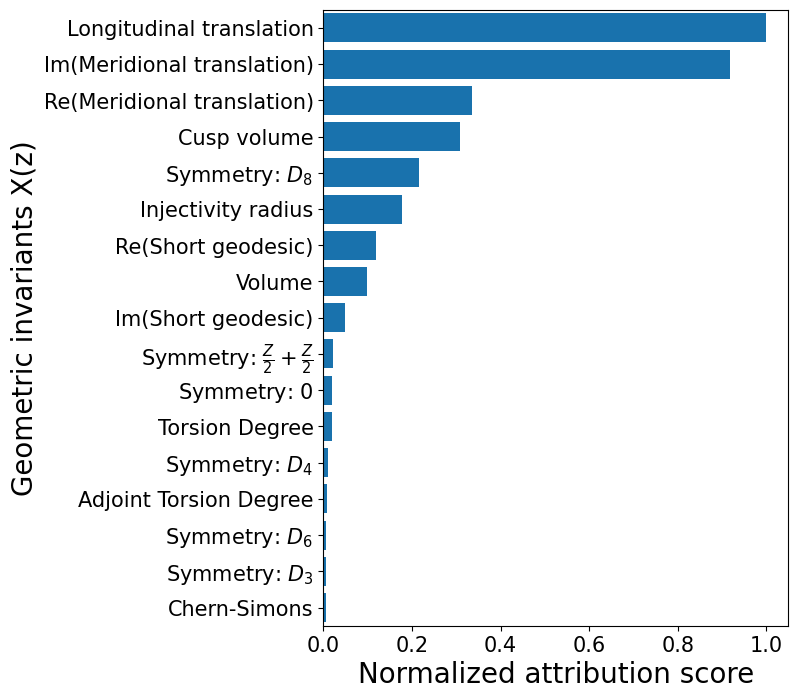

In [11]:
# @title Saliency Analysis
train_X = normalize_features(train_df, column_names, add_target=False).to_numpy()
train_y = train_df[target].to_numpy()


saliencies = np.mean(
    np.abs(jax.grad(loss_fn_t.apply, 1)(trained_params, train_X, train_y)), axis=0)


decreasing_saliency = reversed(sorted(zip(saliencies, display_name_from_short_name.values())))
sorted_saliencies, sorted_columns = zip(*decreasing_saliency)

fig, ax = plt.subplots(figsize=(6,8))
sns.barplot(y=np.array(sorted_columns),
            x=np.array(sorted_saliencies) / max(sorted_saliencies),
            color="#0077c6");

ax.tick_params(labelsize=15);
ax.set_ylabel('Geometric invariants X(z)', fontsize=20);
plt.xlabel('Normalized attribution score', fontsize=20);

### Confirming The Feature Saliency

In [12]:
# @title Confirming the Feature Saliency

#@markdown To confirm the results of the saliency analysis, we re-train the network with
#@markdown only these three features as input to the network.
salient_column_names = ['longitudinal_translation',
                        'meridinal_translation_imag',
                        'meridinal_translation_real']
target = 'signature'

### Confirming the Feature Saliency: Network Setup

In [13]:
# @title Confirming the Feature Saliency: Network Setup (re-run before re-training)

train_X, train_y = get_batch(normed_train_df, salient_column_names, batch_size)

init_params_salient = loss_fn_t.init(rng, train_X, train_y)

opt_init_salient, opt_update_salient = optax.adam(learning_rate)
opt_state_salient = opt_init(init_params_salient)

/opt/homebrew/anaconda3/lib/python3.11/site-packages/haiku/_src/initializers.py:127: UserWarning: Explicitly requested dtype float64  is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  unscaled = jax.random.truncated_normal(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/haiku/_src/base.py:658: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  param = init(shape, dtype)


### Confirming the Feature Saliency: Network Training

In [14]:
# @title Confirming the Feature Saliency: Network Training


#@markdown Re-train the network using only the most salient features.
@jax.jit
def update_salient(params, opt_state, batch_X, batch_y):
  grads = jax.grad(loss_fn_t.apply)(params, batch_X, batch_y)
  upds, new_opt_state = opt_update_salient(grads, opt_state)
  new_params = optax.apply_updates(params, upds)
  return new_params, new_opt_state


trained_params_salient = train(salient_column_names, init_params_salient,
                               opt_state_salient, update_salient)

#@markdown Print the test accuracy. This should be very similar to the test accuracy in
#@markdown the case that all columns / invariants are included, demonstrating that most
#@markdown of the predictve information about the signature is contained in the three
#@markdown selected invariants.
test_X, test_y = get_batch(normed_test_df, salient_column_names)

#@markdown The final below accuracy should be in the low 80%s, probably 0.8 -> 0.85
print("Test Accuracy: ",
      np.mean((predict(trained_params_salient, test_X) - test_y) == 0))

Step count: 0
Train loss: 2.7034947872161865
Validation loss: 2.703305721282959
Step count: 100
Train loss: 2.5607848167419434
Validation loss: 2.5187928676605225
Step count: 200
Train loss: 2.322265148162842
Validation loss: 2.373600721359253
Step count: 300
Train loss: 2.2783355712890625
Validation loss: 2.2464091777801514
Step count: 400
Train loss: 2.121943950653076
Validation loss: 2.1391541957855225
Step count: 500
Train loss: 2.0754849910736084
Validation loss: 2.0554935932159424
Step count: 600
Train loss: 1.94698166847229
Validation loss: 1.9938719272613525
Step count: 700
Train loss: 1.9106123447418213
Validation loss: 1.9485079050064087
Step count: 800
Train loss: 1.8372856378555298
Validation loss: 1.9127235412597656
Step count: 900
Train loss: 1.9250376224517822
Validation loss: 1.8814102411270142
Step count: 1000
Train loss: 1.8776377439498901
Validation loss: 1.8527954816818237
Step count: 1100
Train loss: 1.6571414470672607
Validation loss: 1.8244314193725586
Step count

### Slope vs. Signature: Proposed Linear Relationship

In [15]:
# @title Slope vs. Signature: Proposed Linear Relationship

#@markdown The quantity we proposed was the "natural slope", given by
#@markdown real(longitudinal_translation / meridinal_translation). We show that
#@markdown this is approximately twice the signature (up to a correction term based on
#@markdown other hyperbolic invariants) which we can check by comparing the predictions
#@markdown made by this rule to those made by the previously trained models.


def predict_signature_from_slope(data_X, min_signature, max_signature):
  meridinal_translation = (
      data_X['meridinal_translation_real'] +
      1j * data_X['meridinal_translation_imag'])
  slope = data_X['longitudinal_translation'] / meridinal_translation
  return slope.real / 2

### Proposed Linear Relationship: Scatter plot

Text(0, 0.5, 'Signature')

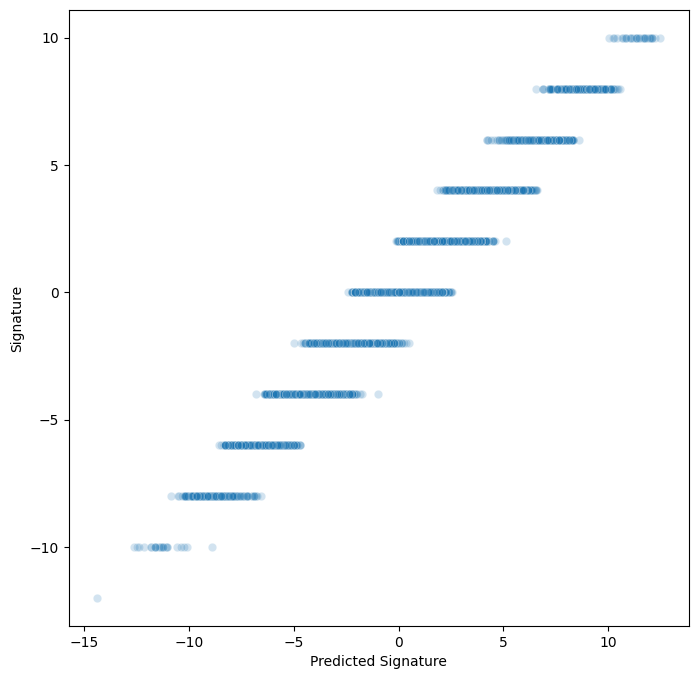

In [16]:
# @title Proposed Linear Relationship: Scatter plot

#@markdown Scatter plot of the slope against predicted signature.
predictions = [
    predict_signature_from_slope(x, min_signature, max_signature)
    for _, x in test_df.iterrows()
]

fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(
    x=predictions, y=test_df[target], alpha=0.2)
ax.set_xlabel('Predicted Signature')
ax.set_ylabel('Signature')

### Proposed Linear Relationship: Test Accuracy


In [17]:
# @title Proposed Linear Relationship: Test Accuracy


#@markdown In order to compute the "test accuracy" in the same way as before, we quantize
#@markdown the predicted signature values to even integers, between min_signature and
#@markdown max_signature.
def quantize(x, min_signature, max_signature):
  return min(max(2 * round(x / 2), min_signature), max_signature)


quantized_predictions = [
    quantize(x, min_signature, max_signature) for x in predictions
]

Now we can compute the "test accuracy" of this prediction.

The value is slightly lower than for the trained network predictors (although still far higher than chance), but this is not unexpected.

Indeed, the proposed rule gives a provable bound on the signature over all knots, instead of maximizing prediction performance over a given finite dataset, as the networks are doing. Although we do use separate training, validation and test datasets for the networks, these are all drawn from approximately the same distribution, whereas the proposed rule could be considered (in some imprecise sense) to have been "trained" on the set of all knots, a very different distribution.

The correction term may also have some bias, for example tending to be positive more often than it is negative, information which the network predictors would be able to use to increase their prediction performance relative to that of the proposed rule.

### Network output here is fixed (unmodified)
We did not modify this part but the result is always `0.738192917391447`

In [18]:
#@markdown The below accuracy will probably be lower than the previous ~80%, but not by much, likely still >70%
print("Test Accuracy: ", np.mean(test_df[target] - quantized_predictions == 0))

Test Accuracy:  0.7356329383964029
